In [0]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
from datetime import datetime
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error

In [84]:
df = pd.read_csv(
    './Sunspots.csv', 
    header=0,
    index_col=0, 
    parse_dates=[0], 
    thousands=",",
    usecols = [1, 2]
    )
df.rename(
    columns={
    'Date':'date',
    'Monthly Mean Total Sunspot Number': 'count',
    },
    inplace=True
)
df.index.rename('date', inplace=True)
df.head()

,count
date,
1749-01-31,96.7
1749-02-28,104.3
1749-03-31,116.7
1749-04-30,92.8
1749-05-31,141.7


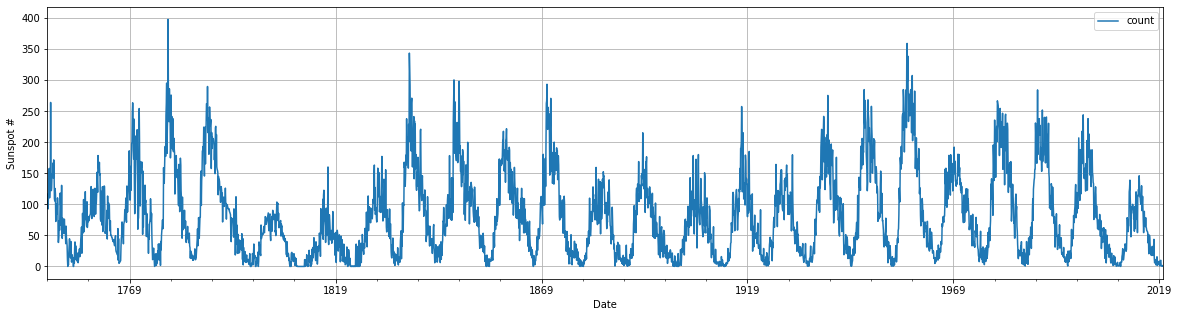

In [80]:
df.plot(figsize=(20, 5))
plt.ylabel('Sunspot #')
plt.xlabel('Date')
plt.grid(True)

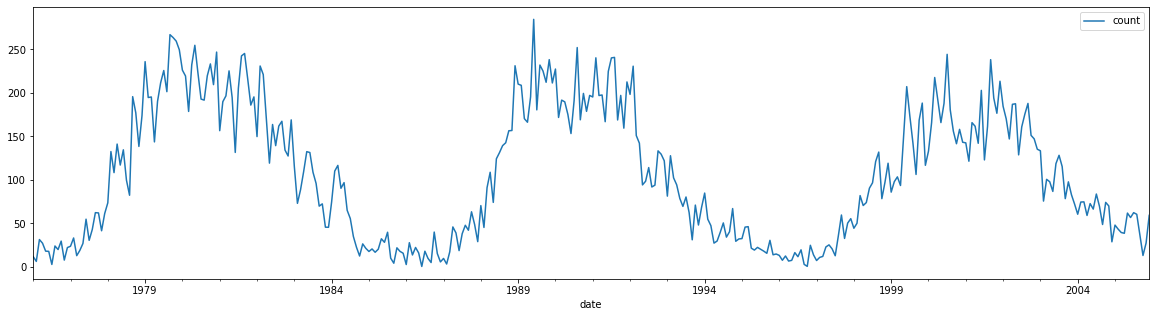

In [87]:
short_df = df[(df.index > '1976-01-01') & (df.index < '2006-01-01')]
short_df.plot(figsize=(20, 5))

In [0]:
decomposition = sm.tsa.seasonal_decompose(df, model='additive', freq=132)

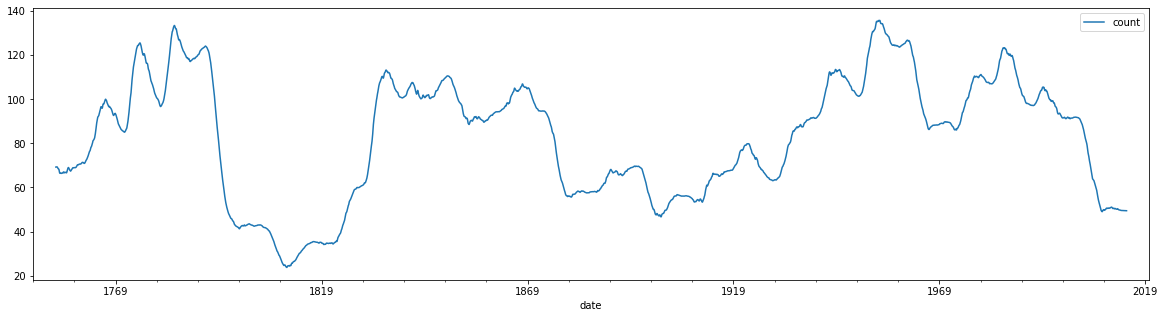

In [130]:
decomposition.trend.plot(figsize=(20, 5))

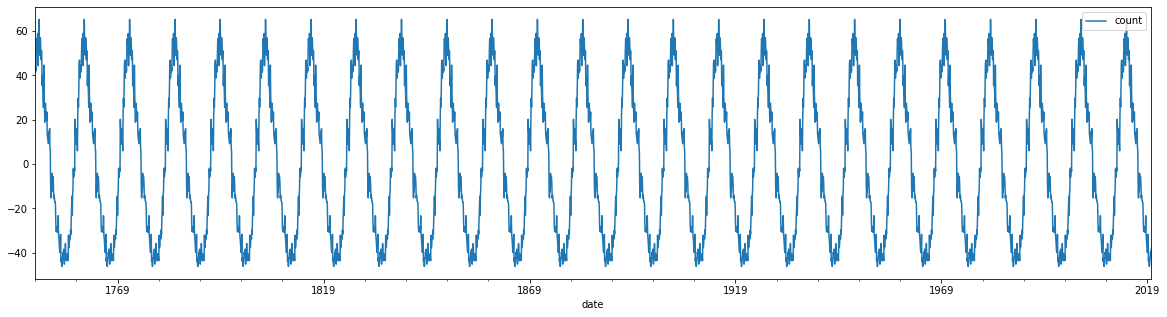

In [131]:
decomposition.seasonal.plot(figsize=(20, 5))

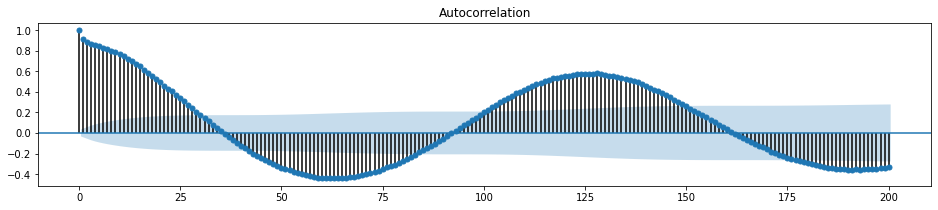

In [174]:
fig, ax = plt.subplots(figsize=(16,3))
plot_acf(df,ax=ax, lags = 200);

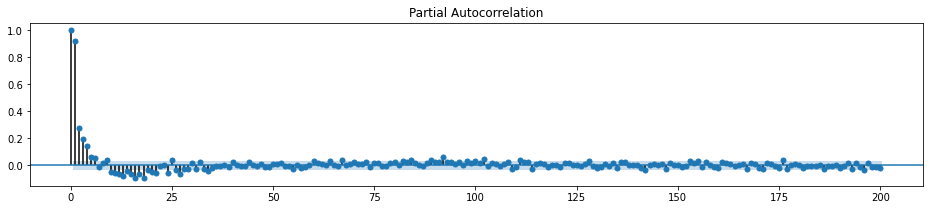

In [173]:
fig, ax = plt.subplots(figsize=(16,3))
plot_pacf(df,ax=ax, lags = 200);

In [134]:
len(df)

3252

In [136]:
train = int(len(df) * .6)
valid = int(len(df) * .2)
test = int(len(df) - train - valid)

train, valid, test

(1951, 650, 651)

In [177]:
train_df, valid_df, test_df = df[0:train], df[train:train + valid], df[train + valid: len(df)]
big_train_df = df[0:train + valid]
len(train_df), len(valid_df), len(test_df), len(big_train_df)

(1951, 650, 651, 2601)

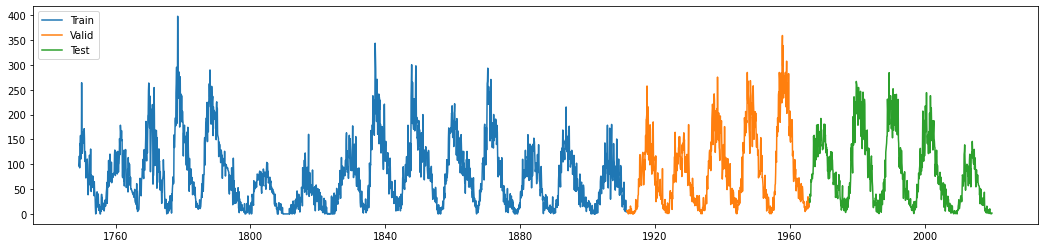

In [152]:
plt.subplots(figsize=(18,4))
plt.plot(train_df)
plt.plot(valid_df)
plt.plot(test_df)
plt.legend(['Train', 'Valid', 'Test'], loc='upper left')
plt.show()

In [0]:
arima_train_df = big_train_df.resample('A').sum()
arima_test_df = test_df.resample('A').sum()
SEASON_MULTY = 11

In [189]:
order = (3,0,3)
seasonal_order = (1,1,0, SEASON_MULTY)
model = sm.tsa.statespace.SARIMAX(arima_train_df, order=order, seasonal_order=seasonal_order)
results = model.fit()
print(results.summary())

                                 Statespace Model Results                                 
Dep. Variable:                              count   No. Observations:                  217
Model:             SARIMAX(3, 0, 3)x(1, 1, 0, 11)   Log Likelihood               -1500.734
Date:                            Sun, 05 Apr 2020   AIC                           3017.468
Time:                                    19:24:01   BIC                           3044.091
Sample:                                12-31-1749   HQIC                          3028.236
                                     - 12-31-1965                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2932      0.422      0.695      0.487      -0.534       1.120
ar.L2          0.4813      0.259   

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [0]:
forecasted = results.forecast(len(arima_test_df))

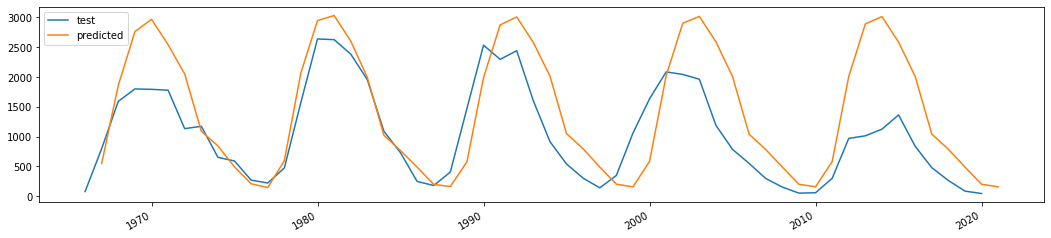

In [224]:
plt.subplots(figsize=(18,4))
plt.plot(arima_test_df,label = 'test')
forecasted.plot(label = 'predicted')
plt.legend(loc='upper left')

In [345]:
base_arima_rmse = mean_squared_error(forecasted.values, arima_test_df['count'].values, squared=False)
base_arima_rmse

727.631443121939

In [185]:
!pip install pmdarima

     |████████████████████████████████| 1.5MB 13.9MB/s 


In [0]:
import pmdarima as pm

In [193]:
grid_model = pm.auto_arima(
    arima_test_df, 
    start_p=0,
    max_p=3,
    start_q=0,
    max_q=3,
    start_P=0,
    max_P=3,
    start_Q=0,
    max_Q=3,
    d=0,
    D=1,
    test='adf',
    m=SEASON_MULTY,
    seasonal=True,
    trace=True,
    error_action='ignore',  
    suppress_warnings=True, 
    stepwise=True
  )

Performing stepwise search to minimize aic
Fit ARIMA: (0, 0, 0)x(0, 1, 0, 11) (constant=True); AIC=684.762, BIC=688.330, Time=0.017 seconds
Fit ARIMA: (1, 0, 0)x(1, 1, 0, 11) (constant=True); AIC=657.024, BIC=664.161, Time=0.425 seconds
Fit ARIMA: (0, 0, 1)x(0, 1, 1, 11) (constant=True); AIC=660.425, BIC=667.562, Time=0.361 seconds
Near non-invertible roots for order (0, 0, 1)(0, 1, 1, 11); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Fit ARIMA: (0, 0, 0)x(0, 1, 0, 11) (constant=False); AIC=684.666, BIC=686.450, Time=0.014 seconds
Fit ARIMA: (1, 0, 0)x(0, 1, 0, 11) (constant=True); AIC=658.995, BIC=664.348, Time=0.038 seconds
Fit ARIMA: (1, 0, 0)x(2, 1, 0, 11) (constant=True); AIC=651.902, BIC=660.823, Time=1.451 seconds
Fit ARIMA: (1, 0, 0)x(3, 1, 0, 11) (constant=True); AIC=649.255, BIC=659.961, Time=3.418 seconds
Near non-invertible roots for order (1, 0, 0)(3, 1, 0, 11); setting score to inf (at least one inverse root too close 

In [194]:
print(grid_model.summary())

                                 Statespace Model Results                                 
Dep. Variable:                                  y   No. Observations:                   55
Model:             SARIMAX(1, 0, 0)x(2, 1, 1, 11)   Log Likelihood                -318.191
Date:                            Sun, 05 Apr 2020   AIC                            648.382
Time:                                    19:25:49   BIC                            659.087
Sample:                                         0   HQIC                           652.352
                                             - 55                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     12.1334     33.966      0.357      0.721     -54.438      78.705
ar.L1          0.8528      0.159   

In [0]:
fitted = grid_model.predict(n_periods=len(arima_test_df))

In [346]:
tuned_arima_rmse = mean_squared_error(fitted, arima_test_df['count'].values, squared=False)
tuned_arima_rmse

492.34007827011067

In [0]:
index_of_fc = pd.date_range(arima_test_df.index[0], periods = len(arima_test_df), freq='A')

fitted_series = pd.Series(fitted, index=index_of_fc)

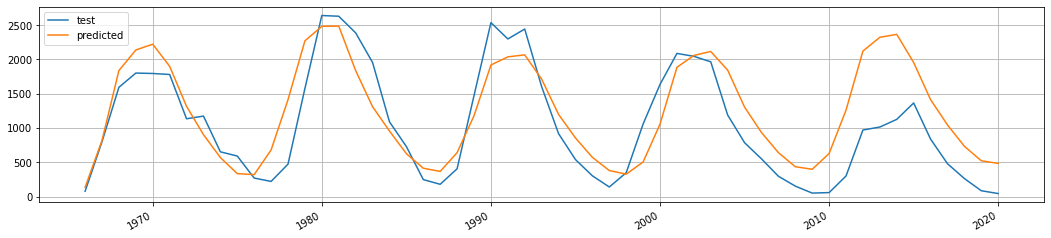

In [341]:
plt.subplots(figsize=(18,4))
plt.plot(arima_test_df,label = 'test')
fitted_series.plot(label = 'predicted')
plt.legend(loc='upper left')
plt.grid(True)

In [0]:
def plot_curves(title, data, y_title, x_title='Epoch', legend=[], x_labels_offset = 0):
    fig = plt.figure(figsize=(8, 4))
        
    for row in data:
        x = range(x_labels_offset, len(row))
        plt.plot(x, row[x_labels_offset:])
    
    plt.title(title)
    plt.ylabel(y_title)
    plt.xlabel(x_title)
    plt.grid(True)
    plt.legend(legend, loc='upper left')
    plt.show()

**RRN**

In [0]:
import tensorflow as tf

In [0]:
window_size = 60
batch_size = 32
shuffle_buffer_size = 1000

In [0]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(batch_size).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [0]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [0]:
train_set = windowed_dataset(train_df['count'].values, window_size, batch_size, shuffle_buffer_size)

In [0]:
valid_set = windowed_dataset(valid_df['count'].values, window_size, batch_size, shuffle_buffer_size)

In [0]:
test_set = windowed_dataset(test_df['count'].values, window_size, batch_size, shuffle_buffer_size)

In [0]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Conv1D, Lambda, Dropout

In [0]:
rrn = Sequential()
rrn.add(Conv1D(filters=60, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]))
rrn.add(LSTM(60, return_sequences=True))
rrn.add(LSTM(60, return_sequences=True))
rrn.add(Dropout(0.5))
rrn.add(Dense(10, activation="relu"))
rrn.add(Dropout(0.5))
rrn.add(Dense(1))
#rrn.add(Lambda(lambda x: x * 400))

rrn.compile(loss='mean_squared_error', optimizer='adam', metrics=[tf.keras.metrics.RootMeanSquaredError()])

In [310]:
history = rrn.fit(train_set, validation_data=valid_set, epochs=20, verbose=1)

Epoch 1/20
60/60 [==============================] - 1s 25ms/step - loss: 8893.0996 - root_mean_squared_error: 94.0809 - val_loss: 12008.7842 - val_root_mean_squared_error: 109.7809
Epoch 2/20
60/60 [==============================] - 1s 13ms/step - loss: 6727.4385 - root_mean_squared_error: 81.7721 - val_loss: 9394.6494 - val_root_mean_squared_error: 96.3975
Epoch 3/20
60/60 [==============================] - 1s 13ms/step - loss: 5093.5376 - root_mean_squared_error: 70.6524 - val_loss: 7033.7500 - val_root_mean_squared_error: 83.3893
Epoch 4/20
60/60 [==============================] - 1s 14ms/step - loss: 3787.3997 - root_mean_squared_error: 61.9548 - val_loss: 5233.1094 - val_root_mean_squared_error: 72.3346
Epoch 5/20
60/60 [==============================] - 1s 14ms/step - loss: 3123.2678 - root_mean_squared_error: 56.2127 - val_loss: 4096.2144 - val_root_mean_squared_error: 64.0637
Epoch 6/20
60/60 [==============================] - 1s 14ms/step - loss: 2724.2942 - root_mean_squared_

In [351]:
score = rrn.evaluate(test_set)
rrn_rmse = score[1]
rrn_rmse

19/19 [==============================] - 0s 7ms/step - loss: 871.6806 - root_mean_squared_error: 29.5736


29.573585510253906

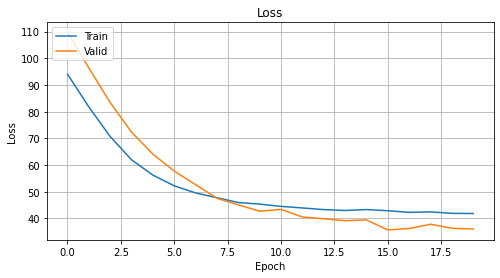

In [311]:
plot_curves(f'Loss', 
            [
              history.history['root_mean_squared_error'], history.history['val_root_mean_squared_error']
            ], 'Loss', 'Epoch',
            [
              'Train', 'Valid'
            ]
            )

In [0]:
rnn_forecast = model_forecast(rrn, test_df['count'].values.reshape(-1, 1), window_size)

In [322]:
rnn_forecast.shape

(592, 60, 1)

In [323]:
len(test_df['count'].values)

651

In [325]:
rnn_forecast[0:-1, -1, 0].shape

(591,)

In [333]:
rnn_forecast = model_forecast(rrn, df['count'].values[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[train + valid - window_size:-1, -1, 0]
len(rnn_forecast)

651

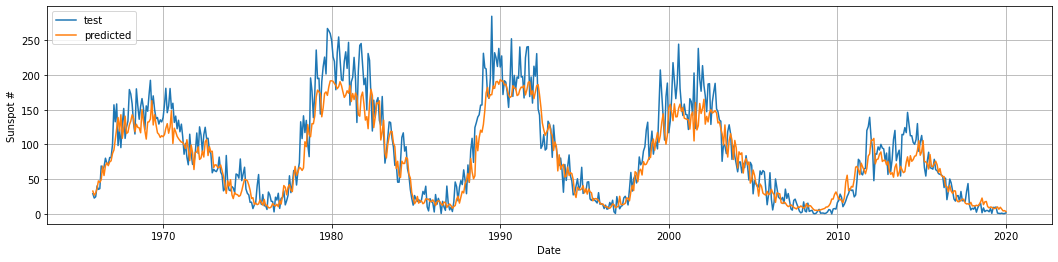

In [342]:
plt.subplots(figsize=(18,4))
plt.plot(test_df.index, test_df['count'].values, label = 'test')
plt.plot(test_df.index, rnn_forecast, label = 'predicted')
plt.ylabel('Sunspot #')
plt.xlabel('Date')
plt.grid(True)
plt.legend(loc='upper left')
plt.show()

Text(0.5, 1.0, 'RMSE')

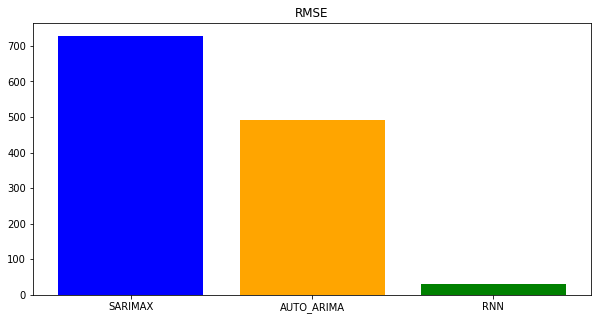

In [356]:
plt.figure(figsize=(10, 5))

plt.bar(['SARIMAX', 'AUTO_ARIMA', 'RNN'],[base_arima_rmse, tuned_arima_rmse, rrn_rmse], color=['Blue', 'Orange', 'Green'])
#plt.ylim(0.4, 0.9)
plt.title('RMSE')